In [ ]:
import os
import random
from glob import glob
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

IMAGENET_PATH = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train" 

all_classes = sorted(os.listdir(IMAGENET_PATH))

subset_ratio = 0.3

class_to_images = {cls: glob(os.path.join(IMAGENET_PATH, cls, "*.JPEG")) for cls in all_classes}

selected_images = {}
for cls, images in class_to_images.items():
    num_select = max(1, int(len(images) * subset_ratio))  
    selected_images[cls] = random.sample(images, num_select)

all_images = [(img, cls) for cls, imgs in selected_images.items() for img in imgs]

train_data, test_data = train_test_split(all_images, test_size=0.2, stratify=[cls for _, cls in all_images], random_state=42)

class ImageNetDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
class Encoder(nn.Module):
    def __init__ (self, code_size=256):
        super (Encoder,self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(4,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,64, kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,3,kernel_size=3, stride=1,padding=1),
            nn.Sigmoid()
        )
        self.fc_layer = nn.Linear(code_size,256*256)

    def forward(self, image, code):
        batch_size= image.shape[0]
        # print(self.fc_layer(code).size())
        expanded_code = self.fc_layer(code).view(batch_size, 1,256,256)
        encoded_input = torch.cat([image, expanded_code],dim=1)
        encoded_image = self.conv_layers(encoded_input)
        return encoded_image

In [ ]:
class Decoder(nn.Module):
    def __init__(self, code_size=256):
        super(Decoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1), 
            # nn.Sigmoid()  # Output in range [0,1]
        )
        self.fc = nn.Linear(256 * 256, code_size)  

    def forward(self, encoded_image):
        """
        encoded_image: Watermarked image (batch, 1, 256, 256)
        """
        batch_size = encoded_image.shape[0]
        extracted_code_map = self.conv_layers(encoded_image)  # (batch, 1, 256, 256)

        extracted_code = self.fc(extracted_code_map.view(batch_size, -1))  # (batch, 256)
        # extracted_code = torch.sigmoid(extracted_code)
        
        return extracted_code


In [5]:
def custom_loss(encoded_image, original_image, extracted_code, true_code, lambda_weight=0.7):
    image_loss = F.mse_loss(encoded_image, original_image)

    code_loss = F.binary_cross_entropy_with_logits(extracted_code, true_code)

    return lambda_weight * image_loss + (1 - lambda_weight) * code_loss


In [6]:
transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),  # Resize to 256x256 (Change if needed)
    transforms.ToTensor(),
])

train_dataset = ImageNetDataset(train_data, transform=transform)
test_dataset = ImageNetDataset(test_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Training samples: 102452
Testing samples: 25614


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
bit_string = "0100110001101111011011000110111101101100011011110110110000100000011110010110111101110101011100100010000001101101011101010110110100100000011010010111001100100000011001110110000101111001001111110010000001101101011101010110100001100001011010000110000101101000"

true_code_list = [int(char) for char in bit_string]

true_code_single = torch.tensor([true_code_list], dtype = torch.float32).to(device)

In [ ]:
from tqdm import tqdm

encoder = Encoder(code_size=256).to(device)
decoder = Decoder(code_size=256).to(device)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)

num_epochs = 3
lambda_value = 0.85


for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    total_loss = 0
    total_bce_loss = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, _ in progress_bar:
        images = images.to(device)
        batch_size = images.shape[0]

        # Repeat the true code for the entire batch
        true_code = true_code_single.repeat(batch_size, 1).to(device)

        # 50% of images will be encoded with watermark**
        encoded_images = encoder(images, true_code)

        # 50% of images will remain unmodified**
        non_encoded_images = images.clone()

        # binary mask: 1 if image is encoded, 0 if it's not
        mask = torch.randint(0, 2, (batch_size, 1), dtype=torch.float32).to(device) 
        mask = mask.view(batch_size, 1, 1, 1)  

        # Select images: Either encoded or original
        final_images = torch.where(mask == 1, encoded_images, non_encoded_images)  

        # pass through decoder
        extracted_code = decoder(final_images)

        # If encoded → `true_code`, else → random noise
        random_noise = torch.rand_like(true_code).to(device)  # Noise for non-encoded images
        target_code = torch.where(mask.squeeze(2).squeeze(2) == 1, true_code, random_noise)  

        # loss
        # print(f"image: {images.shape}")
        # print(f"encoded_image: {encoded_images.shape}")
        # image_loss = F.mse_loss(encoded_images, images)  # Only applies to encoded images
        image_loss = F.l1_loss(encoded_images, images)
        code_loss = F.binary_cross_entropy_with_logits(extracted_code, target_code)  # Applies to both

        loss = lambda_value * image_loss*5 + (1 - lambda_value) * code_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_bce_loss += code_loss.item()

        # gradient sums
        encoder_grad = sum(p.grad.abs().sum().item() for p in encoder.parameters() if p.grad is not None)
        decoder_grad = sum(p.grad.abs().sum().item() for p in decoder.parameters() if p.grad is not None)

        # print(f"Epoch {epoch+1}, Batch Gradient Sum - Encoder: {encoder_grad:.6f}, Decoder: {decoder_grad:.6f}")
        progress_bar.set_postfix(loss=loss.item(), bce_loss=code_loss.item())

    avg_loss = total_loss / len(train_loader)
    avg_bce_loss = total_bce_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}, BCE Loss: {avg_bce_loss:.4f}")


Epoch 1/3: 100%|██████████| 3202/3202 [1:10:58<00:00,  1.33s/it, bce_loss=0.383, loss=0.123] 


Epoch [1/3], Avg Loss: 0.1749, BCE Loss: 0.3808


Epoch 2/3:  10%|▉         | 312/3202 [06:56<1:04:12,  1.33s/it, bce_loss=0.326, loss=0.106] 

In [ ]:
torch.save(encoder.state_dict(), "encoder_big256c.pth")
torch.save(decoder.state_dict(), "decoder_big256c.pth")

In [10]:
encoder_new = Encoder(code_size=256).to(device)
decoder_new = Decoder(code_size=256).to(device)

encoder_new.load_state_dict(torch.load("/kaggle/input/encoder-decoder-256-256/pytorch/default/1/encoder_big256c.pth"))
decoder_new.load_state_dict(torch.load("/kaggle/input/encoder-decoder-256-256/pytorch/default/1/decoder_big256c.pth"))

encoder_new.eval()  # Set to evaluation mode (important for batch norm, dropout layers)
decoder_new.eval()

/tmp/ipykernel_31/876659377.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_new.load_state_dict(torch.load("/kaggle/input/encoder-decoder-256-256/pytorch/default

Decoder(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (fc): Linear(in_features=65536, out_features=256, bias=True)
)

In [ ]:
# 1 batch of test images
images = images.to(device)
train_loader = DataLoader(test_dataset, images.shape[0], shuffle=True, num_workers=4)
test_images, _ = next(iter(train_loader))
test_images = test_images.to(device)
test_codes = true_code_single.repeat(test_images.shape[0], 1).to(device)

print(f"Using fixed code for all images:\n{test_codes[0]}")

encoded_images = encoder_new(test_images, test_codes)

extracted_codes = decoder_new(encoded_images)
predicted_codes = (extracted_codes > 0.5).float()  

accuracy = (predicted_codes == test_codes).float().mean().item() * 100

print(f"Watermark Extraction Accuracy: {accuracy:.2f}%")

Using fixed code for all images:
tensor([0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
        1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
        0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
        1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
        0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1.,
        0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
        1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
       

In [ ]:
train_loader = DataLoader(train_dataset, images.shape[0], shuffle=True, num_workers=4)
test_images, _ = next(iter(train_loader))
test_images = test_images.to(device)

test_codes = true_code_single.repeat(test_images.shape[0], 1).to(device)
print(f"fixed code:\n{test_codes[0]}")

# encoded_images = encoder_new(test_images, test_codes)

extracted_codes = decoder_new(test_images)
predicted_codes = (extracted_codes > 0.5).float()  
# bit-wise accuracy
accuracy = (predicted_codes == test_codes).float().mean().item() * 100

print(f"Watermark Extraction Accuracy: {accuracy:.2f}%")

Using fixed code for all images:
tensor([0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
        1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
        0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
        1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
        0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1.,
        0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
        1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
       

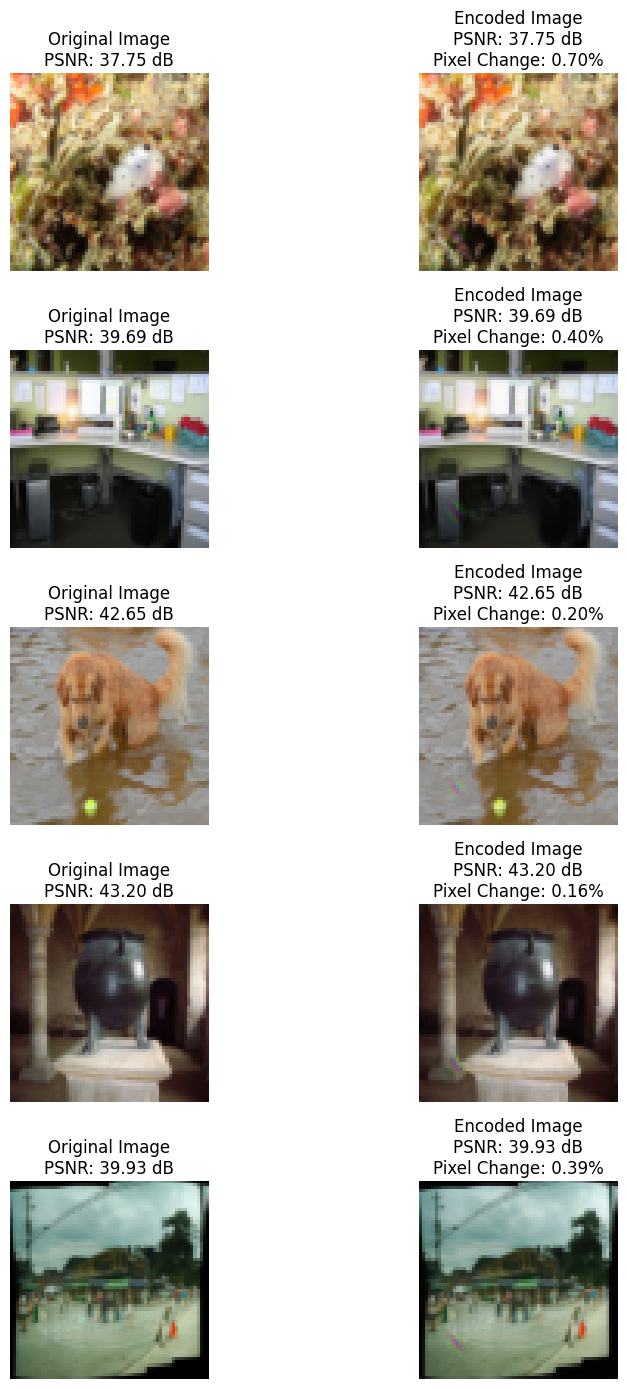

In [ ]:
import matplotlib.pyplot as plt
import random
import torch
import torch.nn.functional as F

def compute_psnr(original, encoded):
    """Compute Peak Signal-to-Noise Ratio (PSNR) between original and encoded images."""
    mse = F.mse_loss(original, encoded)  
    if mse == 0:
        return float("inf") 
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()

def compute_pixel_change(original, encoded, threshold=0.05):
    """Compute percentage of pixels that changed by more than a threshold."""
    diff = torch.abs(original - encoded) 
    changed_pixels = (diff > threshold).float().sum() 
    total_pixels = original.numel()  
    return (changed_pixels / total_pixels).item() * 100 

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)
test_images, _ = next(iter(test_loader))
test_images = test_images.to(device)

random_indices = random.choices(range(test_images.shape[0]), k=5) 
selected_images = test_images[random_indices]

true_code_batch = true_code_single.repeat(selected_images.shape[0], 1).to(device) 
encoded_images = encoder_new(selected_images, true_code_batch)

selected_images = selected_images.cpu().permute(0, 2, 3, 1)  
encoded_images = encoded_images.cpu().permute(0, 2, 3, 1)

psnr_values = [compute_psnr(selected_images[i], encoded_images[i]) for i in range(5)]
pixel_changes = [compute_pixel_change(selected_images[i], encoded_images[i]) for i in range(5)]

fig, axes = plt.subplots(5, 2, figsize=(10, 14))

for i in range(5):
    axes[i, 0].imshow(selected_images[i].numpy().clip(0, 1))  
    axes[i, 0].set_title(f"Original Image\nPSNR: {psnr_values[i]:.2f} dB")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(encoded_images[i].detach().numpy().clip(0, 1))
    axes[i, 1].set_title(f"Encoded Image\nPSNR: {psnr_values[i]:.2f} dB\nPixel Change: {pixel_changes[i]:.2f}%")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


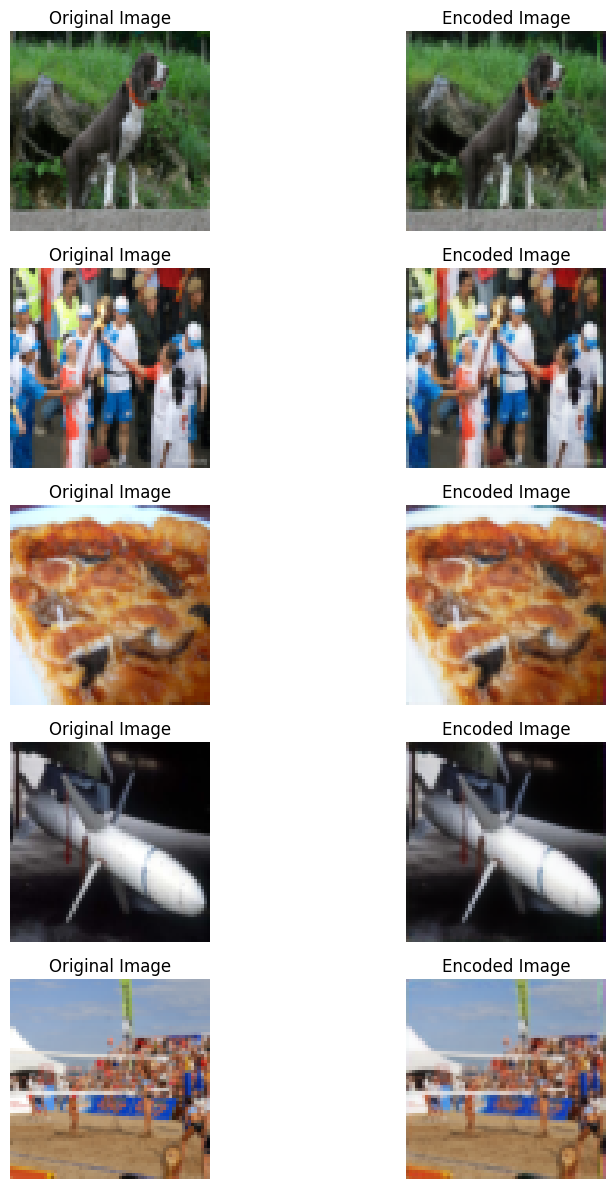

In [ ]:
import matplotlib.pyplot as plt
import random

# batch of test images
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)
test_images, _ = next(iter(test_loader))
test_images = test_images.to(device)

random_indices = random.choices(range(test_images.shape[0]), k=5) 
selected_images = test_images[random_indices]

true_code_batch = true_code_single.expand(selected_images.shape[0], -1).to(device)  
encoded_images = encoder_new(selected_images, true_code_batch)

selected_images = selected_images.cpu().permute(0, 2, 3, 1) 
encoded_images = encoded_images.cpu().permute(0, 2, 3, 1)

fig, axes = plt.subplots(5, 2, figsize=(10, 12))

for i in range(5):
    axes[i, 0].imshow(selected_images[i].numpy().clip(0, 1)) 
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(encoded_images[i].detach().numpy().clip(0, 1))
    axes[i, 1].set_title("Encoded Image")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()
